In [1]:
from itertools import combinations
import argparse
import numpy as np
import pandas as pd
import torch
from webcolors import name_to_rgb
from einops import repeat

In [2]:
def generate_features(ncolors, nshapes):
    '''Generate the raw features for the one-hot dataset.

    Args:
        ncolors (float): Number of one-hot colors to include in the dataset.
        nshapes (float): Number of one-hot shapes to include in the dataset.
    '''
    shapes = torch.eye(nshapes)
    colors = torch.eye(ncolors)
    all_colors = torch.repeat_interleave(colors, nshapes, 0)
    all_shapes = torch.tile(shapes, (ncolors,1))
    all_sprites = torch.hstack([all_colors,all_shapes])
    color_ids = np.argwhere(all_colors>0)[1].numpy()
    shape_ids = np.argwhere(all_shapes>0)[1].numpy()
    return all_sprites, color_ids, shape_ids 


def generate_sprites(sprites_file, colors_list, nshapes):
    '''Generate the individual sprites for the image dataset. 
    
    Args:
        sprites_file (string): Path of the npy images of the black and white sprites.
        colors_list: (list): List of the CSS2 colors to make the sprites.
        nshapes (float): Number of unique shapes to include in the dataset (max=100).
    '''
    sprites = torch.tensor(np.load(sprites_file))[torch.randperm(nshapes)]
    ncolors = len(colors_list)
    all_sprites = torch.zeros([nshapes*ncolors, 3, 32, 32])
    for i, color in enumerate(colors_list):
        colors_matrix = torch.ones([nshapes, 3, 32, 32])
        rgb = torch.tensor(name_to_rgb(color))
        all_color = torch.einsum('ijkl,j->ijkl', colors_matrix, rgb) / 255
        colored_shapes = torch.einsum('ijkl,ikl->ijkl', all_color, sprites) / 255
        all_sprites[i*nshapes:(i+1)*nshapes] = colored_shapes
    all_colors = np.repeat(colors_list, nshapes, 0)
    all_shapes = np.tile(np.arange(nshapes), ncolors)
    return all_sprites, all_colors, all_shapes


def split_dataset(ncolors, nshapes, split_factor=2):
    '''Generate test and train indices that split the dataset evenly over sprites.
    
    Args:
        ncolors (float): Number of colors represented in the dataset.
        nshapes: (float): Number of shapes represented in the dataset.
        split_factor: (int, optional): Number of times each sprite should appear in the SameDifferent dataset (ie. each sprite represented in split_factor comparisons)
    '''
    # Generate the correct indices to split the data in a way that preserves even feature sampling.
    nums = np.arange(ncolors)
    inds = np.zeros([ncolors, nshapes]).astype(int)
    for i in range(split_factor):
        rolled_inds = np.roll(nums, -i)
        inds[rolled_inds, np.arange(nshapes)] = 1
    # Now return the training and testing set indices.
    train_inds = np.ravel(inds).astype(bool)
    test_inds = np.logical_not(train_inds)
    return train_inds, test_inds


def create_comparisons(sprites, colors, shapes):
    '''Generate all possible comparisons for the SameDifferent dataset (works with either image or one-hot datasets).
    
    Args:
        sprites (tensor): Tensor of all sprites (either one-hot sprites (nbatch, nfeatures) or image sprites (nbatch, 3, 32, 32)).
        colors: (np.array): Array of sprite colors.
        shapes (np.array): Array of sprite shape IDs.
    '''
    n = sprites.shape[0]
    comparisons = torch.zeros([n**2, 2, *sprites[0].shape])
    metadata = pd.DataFrame(np.zeros([n**2, 10]), columns=['shape1', 'color1', 'shape2', 'color2', 'ID1', 'ID2', 'compID', 'sameShape', 'sameColor', 'sameSprite'])
    for i, sprite in enumerate(sprites):
        # Add shape, color, and ID fields to metadata.
        sprite1ID =  np.char.array(np.repeat(colors[i], n)) + '-' + np.char.array(np.repeat(shapes[i], n).astype(str))
        sprite2ID = np.char.array(colors) + '-' + np.char.array(shapes.astype(str)) 
        metadata.iloc[i*n:(i+1)*n, :7] = np.array([shapes[i], colors[i], shapes, colors, sprite1ID, sprite2ID, sprite1ID+'/'+sprite2ID], dtype='object')
        # Add the images to the comparisons tensor.
        comparisons[i*n:(i+1)*n, 0] = torch.stack([sprite for _ in range(n)])
        comparisons[i*n:(i+1)*n, 1] = sprites
    metadata['sameShape'] = (metadata['shape1']==metadata['shape2']).astype(int)
    metadata['sameColor'] = (metadata['color1']==metadata['color2']).astype(int)
    metadata['sameSprite'] = (metadata['sameShape'] & metadata['sameColor']).astype(int)
    return comparisons, metadata


def get_split_inds(metadata, split_factor=2):
    '''ASDF
    
    Args:
        metadata (tensor): 
        split_factor: (np.array, optional): Array of sprite colors.
    '''
    match_mask = (metadata['sameColor']==1).values | (metadata['sameShape']==1).values
    nonmatch_mask = np.zeros_like(match_mask)
    for spriteID in np.unique(train_metadata.ID1.values):
        sprite_mask = train_metadata.ID1.values==spriteID
        nonmatch_inds = np.where(sprite_mask & ~match_mask)[0]
        np.random.shuffle(nonmatch_inds)
        nonmatch_mask[nonmatch_inds[:split_factor+1]] = 1 # Grab the first n non-matches.
    return metadata[match_mask | nonmatch_mask].compID.values

In [3]:
color_ids = ['aqua', 'blue', 'fuchsia', 'green', 'grey', 'lime', 'maroon', 'navy', 'olive', 'purple', 'red', 'silver', 'teal', 'white', 'yellow', 'orange']
sprites_file = '../sprites.npy'
nsprites = len(color_ids)
sprites, colors, shapes = generate_sprites(sprites_file, color_ids, nsprites) #generate_features(16, 16) #
all_comparisons, all_metadata = create_comparisons(sprites, colors, shapes)
#torch.save(all_comparisons, 'data/image_comparisons.pt')
split_factors = np.arange(2, 15)

for split in split_factors:
    train_inds, holdout_inds = split_dataset(16, 16, split_factor=split)
    # Generate all comparisons of the valid subset.
    all_train_sprites, all_train_metadata = create_comparisons(sprites[train_inds], colors[train_inds], shapes[train_inds])
    #all_train_metadata = all_train_metadata[all_train_metadata['sameSprite']==0] # Drop double congruencies.
    all_metadata['isTrain_'+'split'+str(split)+'_all'] = all_metadata['compID'].isin(all_train_metadata.compID.values).values
    
    # Limit training examples by subsampling the non-matches.
    train_comp_ids = get_split_inds(train_metadata, split_factor=split)
    all_metadata['isTrain_'+'split'+str(split)+'_reduced'] = all_metadata['compID'].isin(train_comp_ids).values
    
#all_metadata.to_csv('data/image_metadata.csv')

#### Plot example sprites.

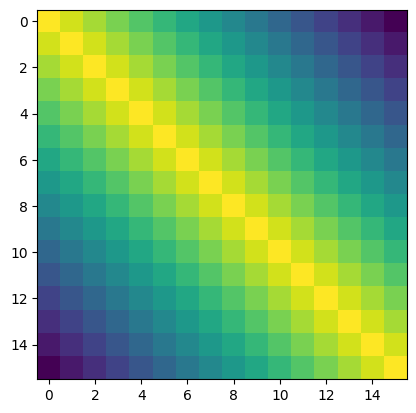

In [69]:
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = cm.get_cmap('cool', 16) #'brg'
x = cmap(np.linspace(0,1,16))
(x - np.roll(x, -1, axis=0)) #.sum(1)
plt.imshow(1-distance_matrix(x,x))

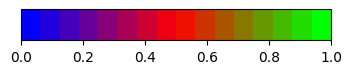

In [67]:
fig, ax = plt.subplots(figsize=(4,0.4))
mpl.colorbar.ColorbarBase(ax, cmap=cmap, orientation='horizontal')

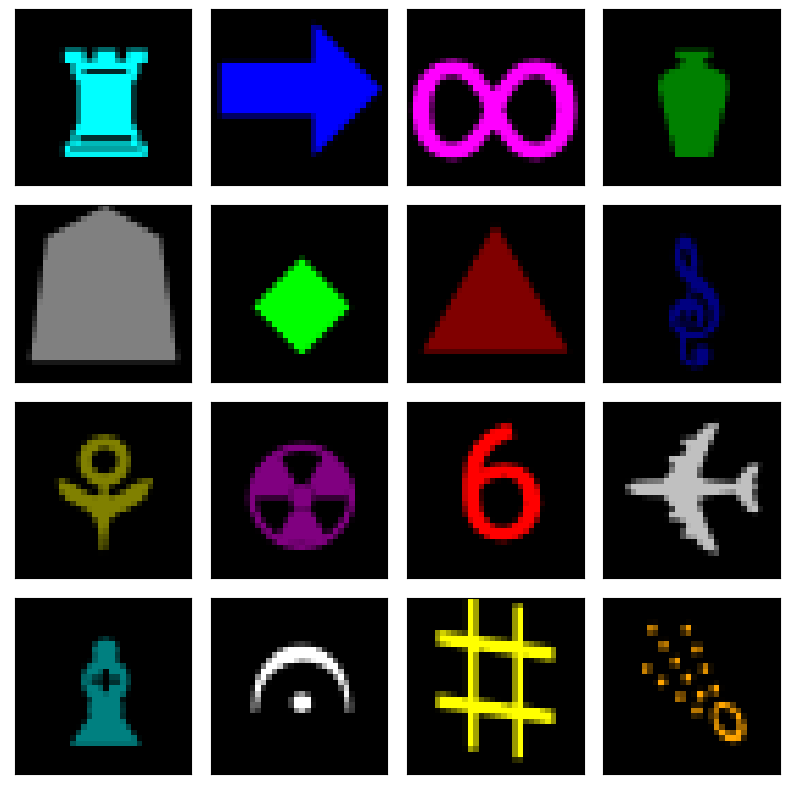

In [33]:
import matplotlib.pyplot as plt

plot_sprites = sprites[train_inds].reshape(4, 4, 3, 32, 32)

fig, axes = plt.subplots(4, 4, figsize=(8,8), sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        axes[i, j].imshow(np.rot90(plot_sprites[i, j].swapaxes(0,2), k=3))
        
for ax in np.ravel(axes):
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
#plt.savefig('example_sprites.png')

#### Plot some example comparisons.

In [3]:
color_ids = ['aqua', 'fuchsia']
sprites_file = '../sprites.npy'
sprites, colors, shapes = generate_sprites(sprites_file, color_ids, 2)
train_inds, holdout_inds = split_dataset(2, 2, split_factor=2)
train_comps, train_metadata = jons_create_comparisons(sprites, colors, shapes, train_inds, split_factor=2, ncolors=2, nshapes=2)

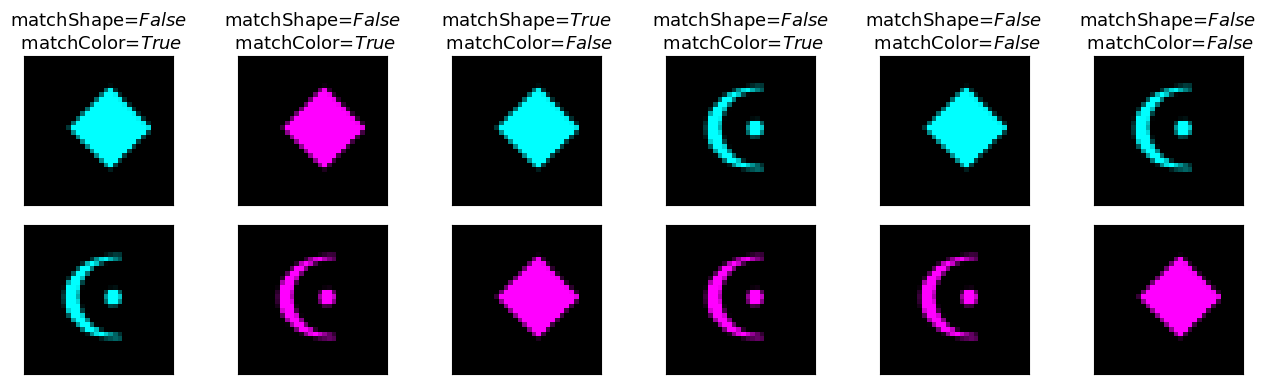

In [7]:
import matplotlib.pyplot as plt
from matplotlib import rc

fig, axes = plt.subplots(2, 6, figsize=(13,4), sharex=True, sharey=True)
matches = ['matchShape=$False$ \n matchColor=$True$',
           'matchShape=$False$ \n matchColor=$True$',
           'matchShape=$True$ \n matchColor=$False$',
           'matchShape=$False$ \n matchColor=$True$',
           'matchShape=$False$ \n matchColor=$False$',
           'matchShape=$False$ \n matchColor=$False$',]
nmatch_inds = [(0, 3), (1, 2)]
nmatch_comps = torch.stack([torch.stack([sprites[ind[0]], sprites[ind[1]]]) for ind in nmatch_inds])
comps = torch.cat([train_comps, nmatch_comps])

for i in range(6):
    axes[0,i].set_title(matches[i], fontsize=13)
    axes[0,i].imshow(comps[i, 0].swapaxes(0,2))
    axes[1,i].imshow(comps[i, 1].swapaxes(0,2))
for ax in np.ravel(axes):
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.savefig('example_comparisons.png')

In [ ]:
def parse_args():
    color_ids = ['aqua', 'blue', 'fuchsia', 'green', 'grey', 'lime', 'maroon', 'navy', 'olive', 'purple', 'red', 'silver', 'teal', 'white', 'yellow', 'orange']
    ap = argparse.ArgumentParser()
    ap.add_argument('sprites_path', help='Path of sprites data to generate the dataset.', required=False)
    ap.add_argument('-s', '--nShapes', type=str, default=16, help='Number of shapes to include in the datasets.')
    ap.add_argument('-c', '--nColors', type=str, default=16, help='Number of colors to include in the datasets.')
    ap.add_argument('-l', '--colors', default=color_ids, help='Colors to use when generating the dataset.')
    ap.add_argument('-p', '--splits', nargs='*', default=np.arange(2, 15), help='Split factors to use when generating the dataset.')
    args = ap.parse_args() 
    return args

In [ ]:
def reduce_dataset(comparisons, metadata, split_factor=16, ncolors=16, nshapes=16):
    '''Reduce the number of comparisons in the dataset while ensuring that 
    
    Args:
        comparisons (tensor): Tensor of all SameDifferent comparisons (one-hot sprites: (nbatch, nfeatures) or image sprites: (nbatch, 3, 32, 32)).
        metadata: (pd.DataFrame): 
        split_factor (np.array, optional): 
    '''
    # Get the ID's for sprites that we want to train on.
    good_sprite_inds, _ = split_dataset(ncolors, nshapes, split_factor=split_factor)
    temp_metadata = metadata[good_sprite_inds.repeat(ncolors*nshapes)]
    good_sprite_ids = np.where(good_sprite_inds)[0]
    # Create a mask that filters out comparisons that include hold-out sprites we don't want to train on.
    good_mask = np.isin(metadata.ID1.values, good_sprite_ids) & np.isin(metadata.ID2.values, good_sprite_ids)
    same_color_inds = (metadata['sameColor']==1).values
    same_shape_inds = (metadata['sameShape']==1).values
    match_mask = good_mask & same_color_inds | same_shape_inds
    # Iterate over unique sprites to get indices of non-match.
    nonmatch_mask = np.zeros_like(match_mask)
    good_match_mask = np.zeros_like(match_mask)
    for sid in good_sprite_ids:
        id_mask = metadata.ID1.values==sid
        # Sample n-split-factor random matches and non-matches for each shape.
        nonmatch_inds = np.argwhere((good_mask & id_mask & ~match_mask)>0).T[0]
        match_inds = np.argwhere((good_mask & id_mask & match_mask)>0).T[0]
        np.random.shuffle(nonmatch_inds)
        nonmatch_mask[nonmatch_inds[:split_factor+1]] = 1 # Grab the first n non-matches.
        good_match_mask[match_inds] = 1
    comps = np.concatenate([comparisons[good_match_mask], comparisons[nonmatch_mask]])
    metadata = pd.concat([metadata[good_match_mask], metadata[nonmatch_mask]])
    return comps, metadata 
